In [1]:
import torch
from torch_geometric.data import Data
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import torch
from torch.utils.data import Dataset, ConcatDataset, random_split
from torch_geometric.loader import DataLoader
import torch_geometric

In [2]:
fileset = {}

sig_dir = '/mdsmlvol/rechits_v4/point_clouds/'
fileset['sample'] = [sig_dir + f'BToKPhi_MuonLLPDecayGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_{str(i).zfill(7)}_point_clouds.pt' for i in range(328)]
# fileset['sample'] = [sig_dir + f'BToKPhi_MuonLLPDecayGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_{str(i).zfill(7)}_graphs.pt' for i in range(2)]

# bkg_dir = '/ceph/cms/store/user/aaportel/B-Parking/rechits_v2/ParkingBPH1_2018A/'
# fileset['background'] = [bkg_dir + f'ParkingBPH1_2018A_{str(i).zfill(7)}.root' for i in range(380)]

In [3]:
shuffle_dataset = True
batch_size = 64
random_seed = 6969
split_ratio = 0.8  # 80% of the data for training, 20% for testing

# Set random seed for reproducibility
torch.manual_seed(random_seed)

datasets = [torch.load(fp) for fp in fileset['sample']]
dataset = ConcatDataset(datasets)

dataset_size = len(dataset)
train_size = int(split_ratio * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size, shuffle=shuffle_dataset)
test_loader = DataLoader(test_dataset, batch_size, shuffle=shuffle_dataset)

In [33]:
class ParticleStaticEdgeConv(torch_geometric.nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(ParticleStaticEdgeConv, self).__init__(aggr='max')
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * in_channels, out_channels[0], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[0]), 
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels[0], out_channels[1], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels[1], out_channels[2], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[2]),
            torch.nn.ReLU()
        )

    def forward(self, x, edge_index, k):
        
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, edge_index, x_i, x_j):
        tmp = torch.cat([x_i, x_j - x_i], dim = 1)

        out_mlp = self.mlp(tmp)

        return out_mlp

    def update(self, aggr_out):
        return aggr_out

class ParticleDynamicEdgeConv(ParticleStaticEdgeConv):
    def __init__(self, in_channels, out_channels, k=7):
        super(ParticleDynamicEdgeConv, self).__init__(in_channels, out_channels)
        self.k = k
        self.skip_mlp = torch.nn.Sequential(
            torch.nn.Linear(in_channels, out_channels[2], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[2]),
        )
        self.act = torch.nn.ReLU()

    def forward(self, pts, fts, batch=None):
        edges = torch_geometric.nn.knn_graph(pts, self.k, batch, loop=False, flow=self.flow)
        aggrg = super(ParticleDynamicEdgeConv, self).forward(fts, edges, self.k)
        x = self.skip_mlp(fts)
        out = torch.add(aggrg, x)
        return self.act(out)


class ParticleNet(torch.nn.Module):

    def __init__(self, settings):
        super().__init__()
        previous_output_shape = settings['input_features']

        self.input_bn = torch_geometric.nn.BatchNorm(settings['input_features'])

        self.conv_process = torch.nn.ModuleList()
        for layer_idx, layer_param in enumerate(settings['conv_params']):
            K, channels = layer_param
            self.conv_process.append(ParticleDynamicEdgeConv(previous_output_shape, channels, k=K).to(DEVICE))
            previous_output_shape = channels[-1]



        self.fc_process = torch.nn.ModuleList()
        for layer_idx, layer_param in enumerate(settings['fc_params']):
            drop_rate, units = layer_param
            seq = torch.nn.Sequential(
                torch.nn.Linear(previous_output_shape, units),
                torch.nn.Dropout(p=drop_rate),
                torch.nn.ReLU()
            ).to(DEVICE)
            self.fc_process.append(seq)
            previous_output_shape = units


        self.output_mlp_linear = torch.nn.Linear(previous_output_shape, settings['output_classes'])
        self.output_activation = torch.nn.Softmax(dim=0)

    def forward(self, batch):
        fts = self.input_bn(batch.x)
        pts = batch.pos

        for idx, layer in enumerate(self.conv_process):
          fts = layer(pts, fts, batch.batch)
          pts = fts

        x = torch_geometric.nn.global_mean_pool(fts, batch.batch)

        for layer in self.fc_process:
            x = layer(x)

        x = self.output_mlp_linear(x)
        x = self.output_activation(x)
        return x

In [34]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = "cpu"
print(DEVICE)
settings = {
    "conv_params": [
        (16, (64, 64, 64)),
        (16, (128, 128, 128)),
        (16, (256, 256, 256)),
    ],
    "fc_params": [
        (0.1, 256)
    ],
    "input_features": 17,
    "output_classes": 1,
}

model = ParticleNet(settings)
print(model)

cuda
ParticleNet(
  (input_bn): BatchNorm(17)
  (conv_process): ModuleList(
    (0-2): 3 x ParticleDynamicEdgeConv()
  )
  (fc_process): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): ReLU()
    )
  )
  (output_mlp_linear): Linear(in_features=256, out_features=1, bias=True)
  (output_activation): Softmax(dim=0)
)


In [37]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming the model and data loaders are defined as per your script

# Define the training loop
def train(model, device, train_loader, optimizer):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, data.y.view(-1, 1).type_as(output))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Define the evaluation/testing loop
def evaluate(model, device, loader):
    model.eval()
    targets = []
    outputs = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            targets.extend(data.y.view(-1, 1).cpu().numpy())
            outputs.extend(output.cpu().numpy())

    return targets, outputs

# Setup optimizer
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# Number of training epochs
epochs = 10

# Training loop
for epoch in range(epochs):
    train_loss = train(model, DEVICE, train_loader, optimizer)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')




/opt/conda/envs/mlllp/lib/python3.11/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1, Train Loss: 1.6600
Epoch 2, Train Loss: 1.6483
Epoch 3, Train Loss: 1.6465
Epoch 4, Train Loss: 1.6451
Epoch 5, Train Loss: 1.6440
Epoch 6, Train Loss: 1.6429
Epoch 7, Train Loss: 1.6422
Epoch 8, Train Loss: 1.6414
Epoch 9, Train Loss: 1.6407
Epoch 10, Train Loss: 1.6403


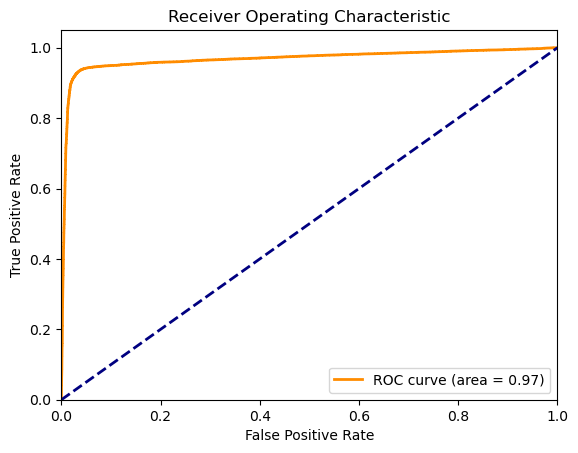

In [38]:
# Evaluation on the test set
targets, outputs = evaluate(model, DEVICE, test_loader)

# Compute ROC curve and ROC area
targets = np.array(targets)
outputs = np.array(outputs)
fpr, tpr, _ = roc_curve(targets, outputs)
roc_auc = roc_auc_score(targets, outputs)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()